# VSB Power Line Fault Detection
Medium voltage overhead power lines run for hundreds of miles to supply power to cities. These great distances make it expensive to manually inspect the lines for damage that doesn't immediately lead to a power outage, such as a tree branch hitting the line or a flaw in the insulator. These modes of damage lead to a phenomenon known as partial discharge — an electrical discharge which does not bridge the electrodes between an insulation system completely. Partial discharges slowly damage the power line, so left unrepaired they will eventually lead to a power outage or start a fire.

Your challenge is to detect partial discharge patterns in signals acquired from these power lines with a new meter designed at the ENET Centre at VŠB. Effective classifiers using this data will make it possible to continuously monitor power lines for faults.

ENET Centre researches and develops renewable energy resources with the goal of reducing or eliminating harmful environmental impacts. Their efforts focus on developing technology solutions around transportation and processing of energy raw materials.

By developing a solution to detect partial discharge you’ll help reduce maintenance costs, and prevent power outages.

> The full git repo for my approach to this project is at: https://github.com/jeffreyegan/VSB_Power_Line_Fault_Detection

## Data Exploration and Preparation

### Data Description
Faults in electric transmission lines can lead to a destructive phenomenon called partial discharge. If left alone, partial discharges can damage equipment to the point that it stops functioning entirely. Your challenge is to detect partial discharges so that repairs can be made before any lasting harm occurs.

Each signal contains 800,000 measurements of a power line's voltage, taken over 20 milliseconds. As the underlying electric grid operates at 50 Hz, this means each signal covers a single complete grid cycle. The grid itself operates on a 3-phase power scheme, and all three phases are measured simultaneously. 

### File Descriptions
**metadata_[train/test].csv**
*         id_measurement: the ID code for a trio of signals recorded at the same time.
*         signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test, so the first ID in train is '0' but the first ID in test is '8712'.
*         phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.
*         target: 0 if the power line is undamaged, 1 if there is a fault.

**[train/test].parquet** : The signal data. Each column contains one signal; 800,000 int8 measurements as exported with pyarrow.parquet version 0.11. Please note that this is different than our usual data orientation of one row per observation; the switch makes it possible loading a subset of the signals efficiently. If you haven't worked with Apache Parquet before, please refer to either the Python data loading starter kernel.
 
**sample_submission.csv**: a valid sample submission.
    
### Data Background Information
As you may notice, the signal data comes from the real environment, not a lab, and they contain a lot of background noise. These signals are measured by our patented device with lower sampling rate (cost efficiency purpose) therefore I do not recommend to use any other publicly available dataset containing partial discharge patterns (PD patterns). - also we deployed the metering devices on more than 20 different locations. This implies that the spectrum of noise and quality of PD's are so different from each other, that the correct and robust classification is a still ongoing problem (the main motivation of this competition). The comparison and broadening of our view is also considered as beneficial and necessary in our research.

PD pattern is therefore the main star tonight and there is a lot of literature about this phenomenon. I would recommend to read some papers, during my dissertation I tried a lot of different feature extraction models, but those based on fundamentals worked the best. In general the imbalanced dataset is very natural because PD pattern implies some degradation or damage of the observed system which is happening (fortunately) less often than the states when the system is operating correctly.

In our case, the measurements on the medium voltage overhead lines, PD pattern may look like this (pd_pattern.png). But because of a lot of various noise interference (overhead lines work as a huge antena grabbing all signals around), a lot of interpolated patterns may look similar (see samples.png).

To use any kind of wavelet transformation is very reasonable, butterworth filter was helpful for me to suppress the sine shape, DWT to obtain its close approximation - sometimes it is disrupted, and denoising with feature extractions are the alchemy of this competition.
    
### Load Data

In [1]:
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
subset_train = pq.read_pandas("../input/vsb-power-line-fault-detection/train.parquet", columns=[str(i) for i in range(9)]).to_pandas()

Text(0,0.5,'Amplitude [bit]')

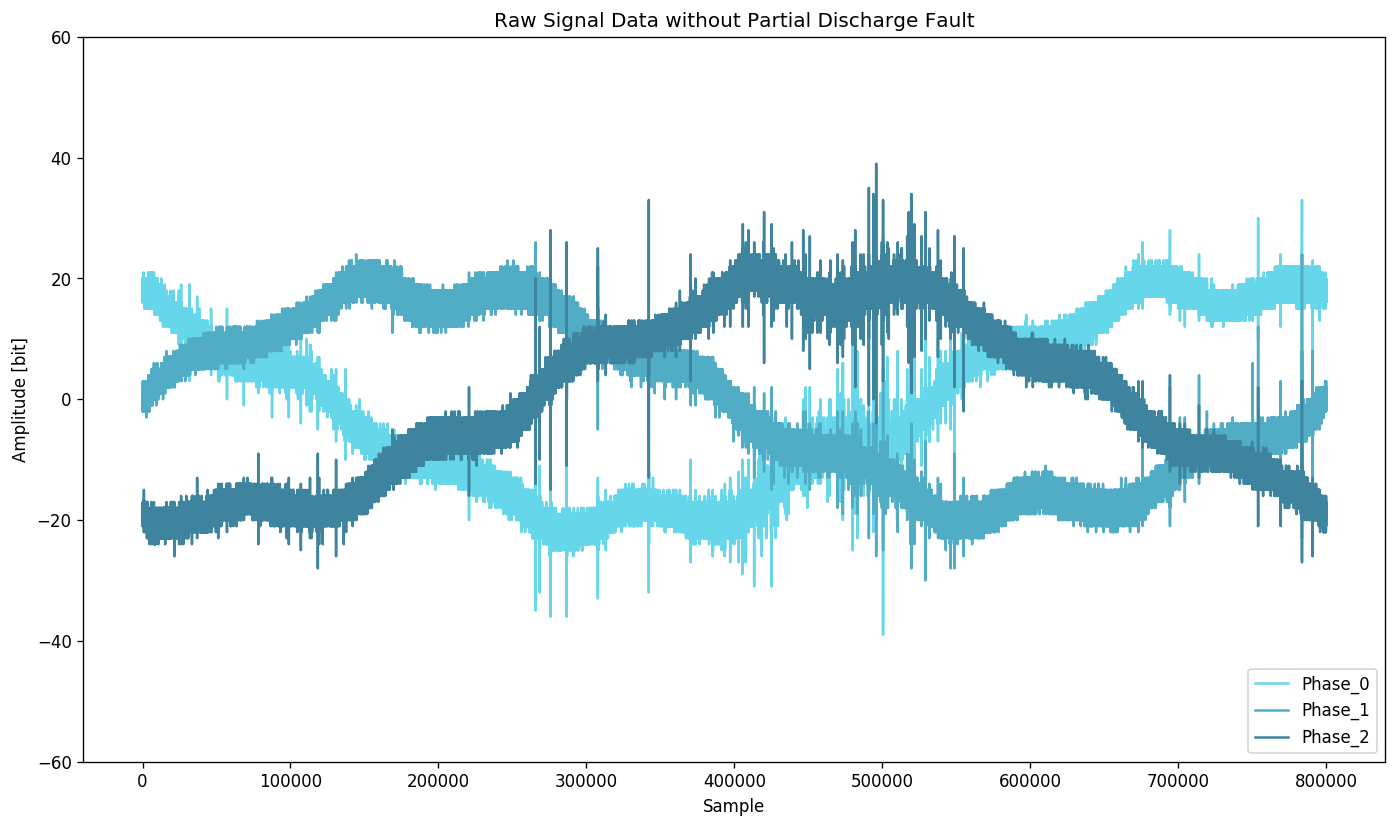

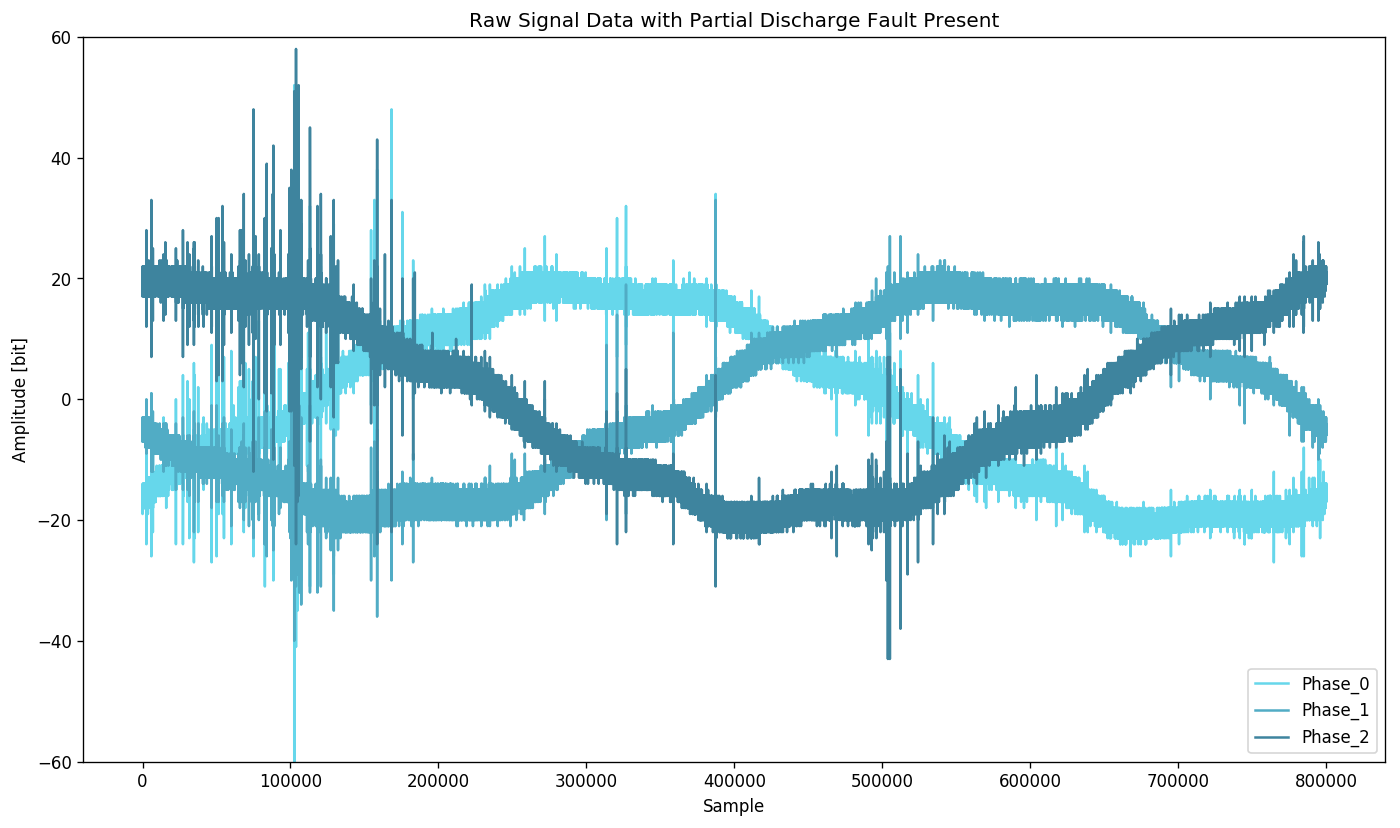

In [3]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["0"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["1"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["2"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["3"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["4"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["5"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data with Partial Discharge Fault Present')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

/opt/conda/lib/python3.6/site-packages/pywt/_multilevel.py:148: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = a[[slice(s) for s in d.shape]]


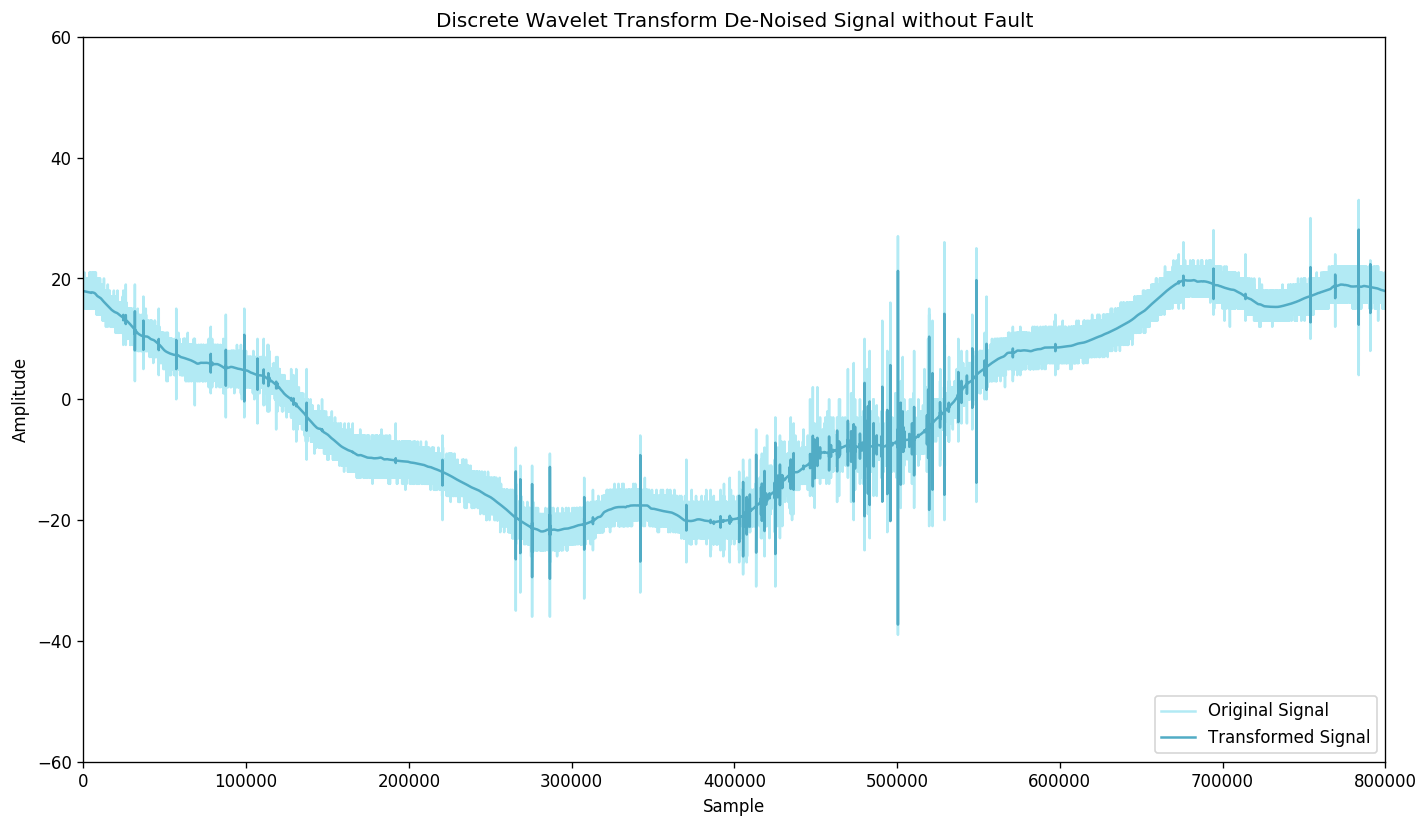

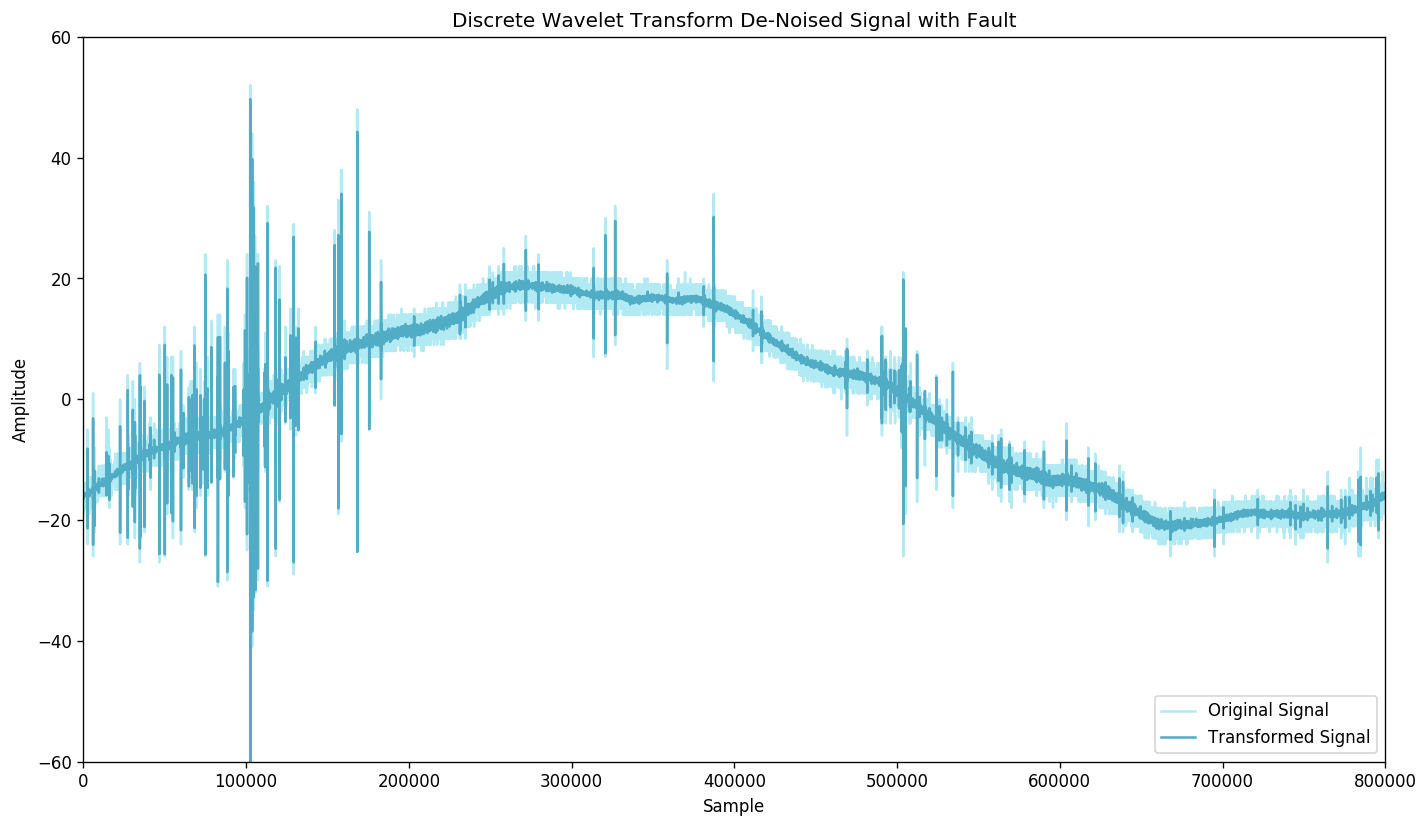

In [4]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(subset_train["0"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(subset_train["3"], wavelet="db4", level=1, title=title1 )

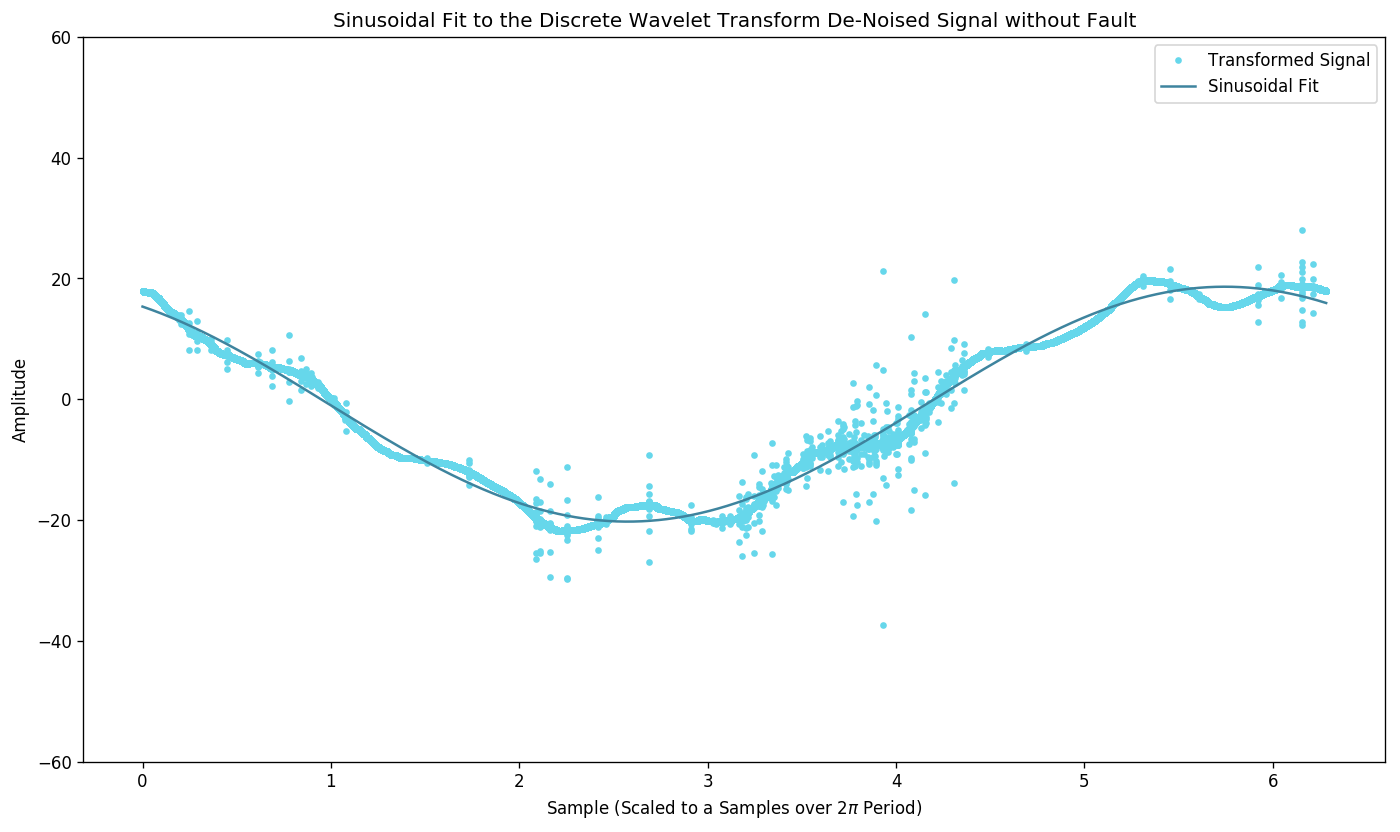

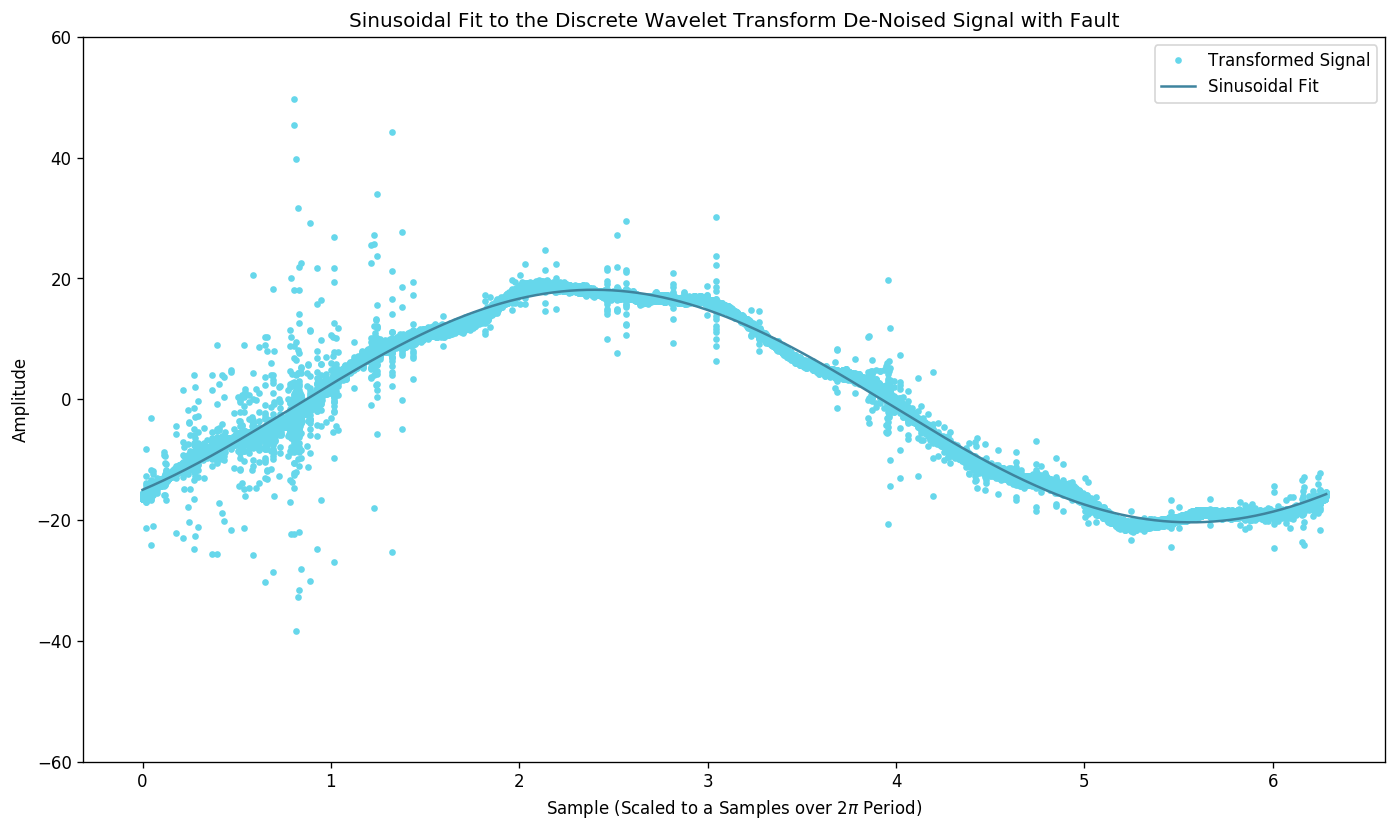

In [5]:
from scipy.optimize import leastsq

def fit_sinusoid(signal, title):
    t = np.linspace(0, 2*np.pi, len(signal))  # data covers one period
    guess_mean = np.mean(signal)
    guess_std = 3*np.std(signal)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 20

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - signal
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(t, signal, '.', color=blues[0], label="Transformed Signal")
    plt.plot(t, signal_fit, label="Sinusoidal Fit", color=blues[2])
    plt.xlabel(r"Sample (Scaled to a Samples over 2$\pi$ Period)")
    plt.ylabel("Amplitude")
    plt.ylim((-60, 60))
    plt.title(title)
    plt.legend()
    plt.show()
    return signal_fit

title0 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal without Fault"
title1 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal with Fault"
signal_fit0 = fit_sinusoid(signal_0, title0)
signal_fit1 = fit_sinusoid(signal_1, title1)

In [6]:
def find_pd_probable(signal_fit, condition):
    first_derivative = np.gradient(signal_fit)
    return [i for i, elem in enumerate(first_derivative) if condition(elem)]

high_prob_region0 = find_pd_probable(signal_fit0, lambda e: e>0)
high_prob_region1 = find_pd_probable(signal_fit1, lambda e: e>0)

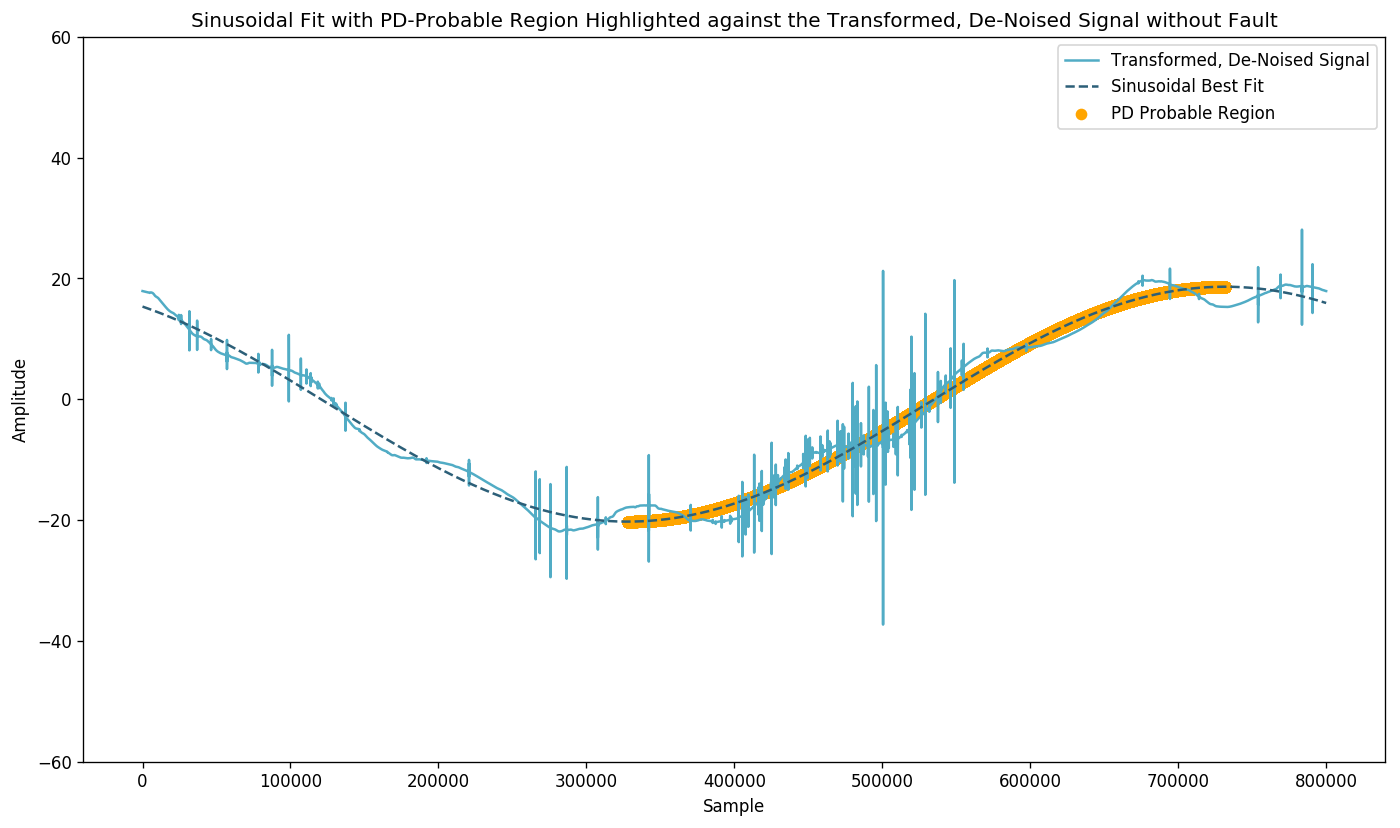

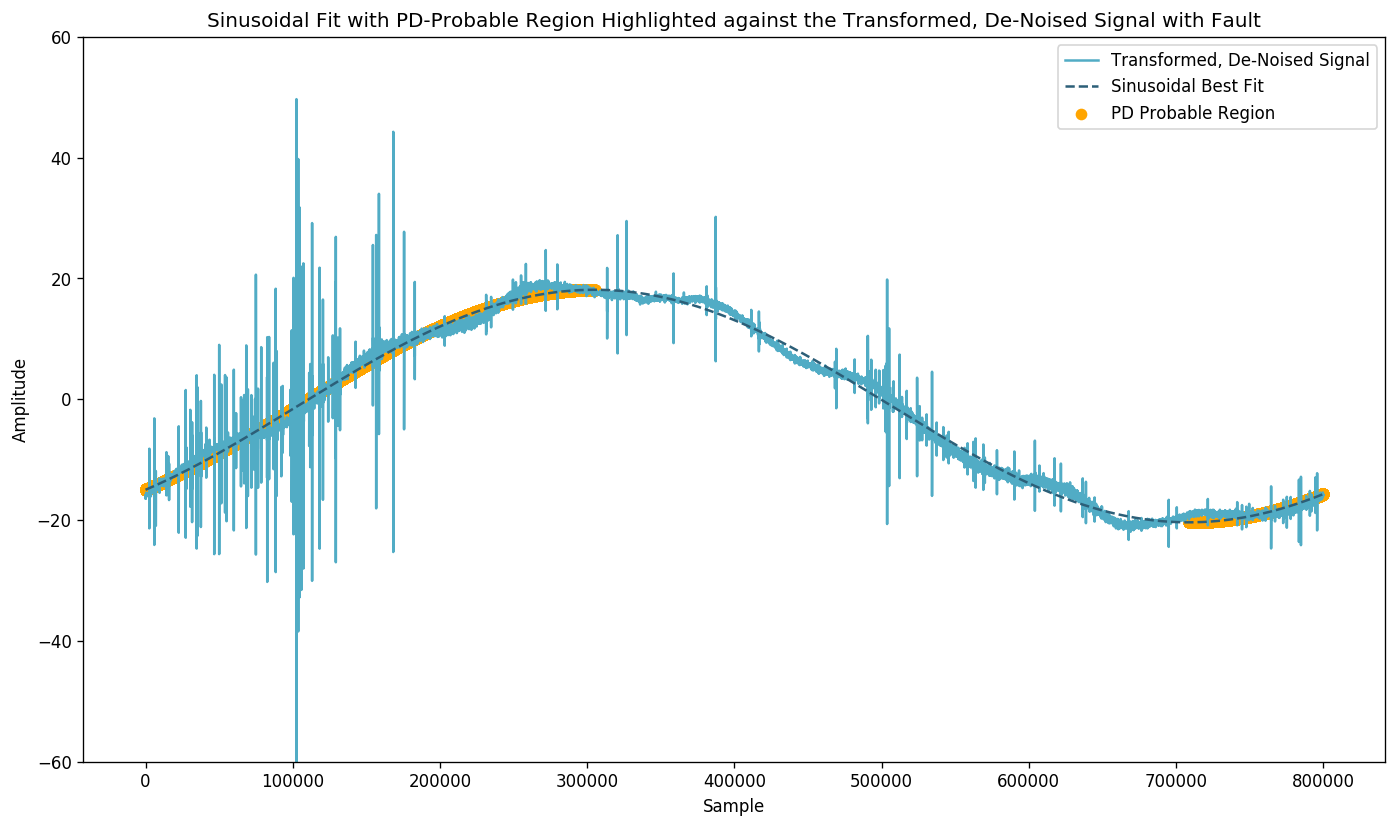

In [7]:
def plot_pd_probable(signal, signal_fit, high_prob_region, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal, color=blues[1], label="Transformed, De-Noised Signal")
    plt.plot(signal_fit, '--', color=blues[3], label="Sinusoidal Best Fit")
    plt.scatter(high_prob_region, signal_fit[high_prob_region], color="orange", label="PD Probable Region")
    plt.legend()
    plt.ylim((-60, 60))
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")
    plt.title(title)
    return

title0 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal without Fault"
title1 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal with Fault"
plot_pd_probable(signal_0, signal_fit0, high_prob_region0, title0)
plot_pd_probable(signal_1, signal_fit1, high_prob_region1, title1)

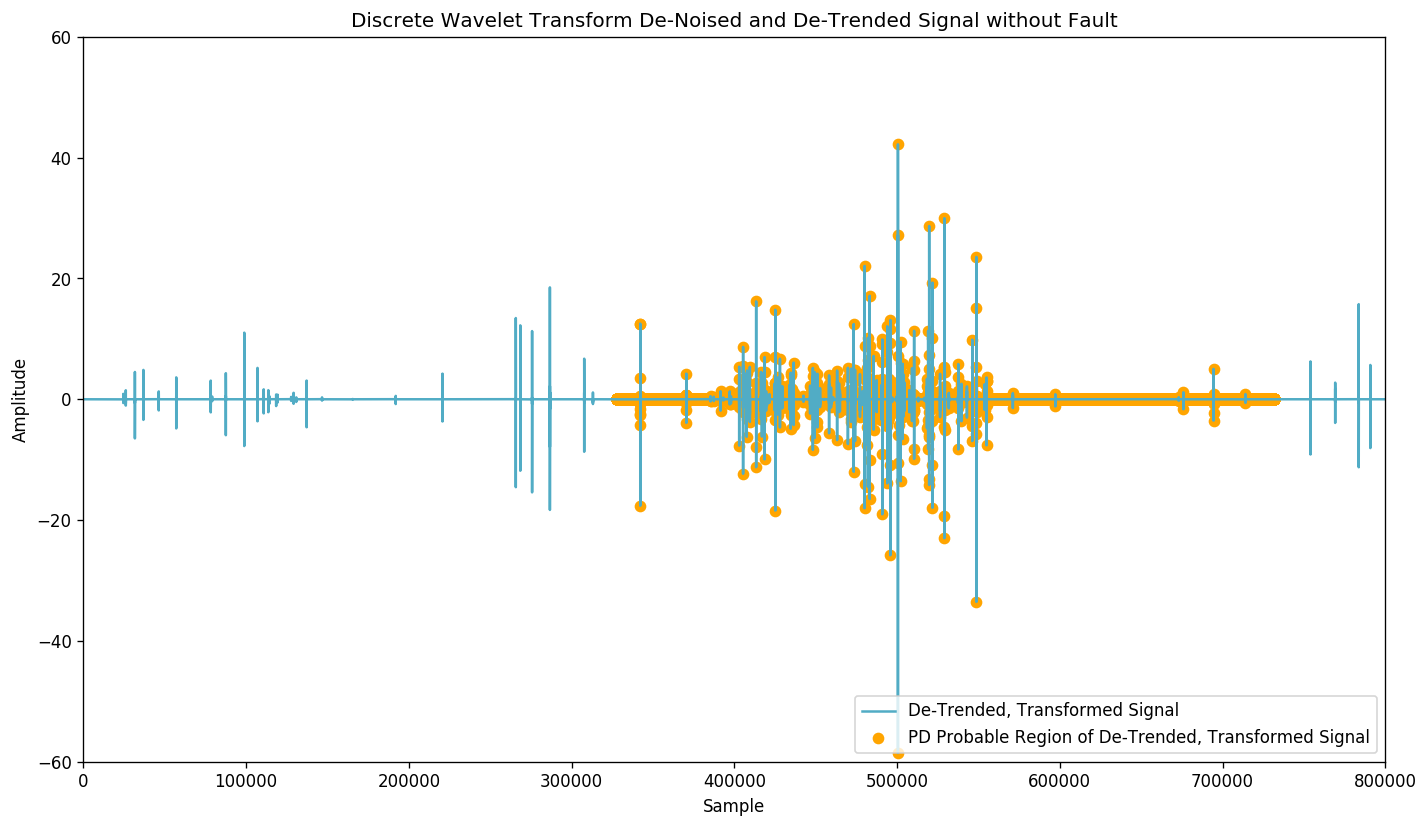

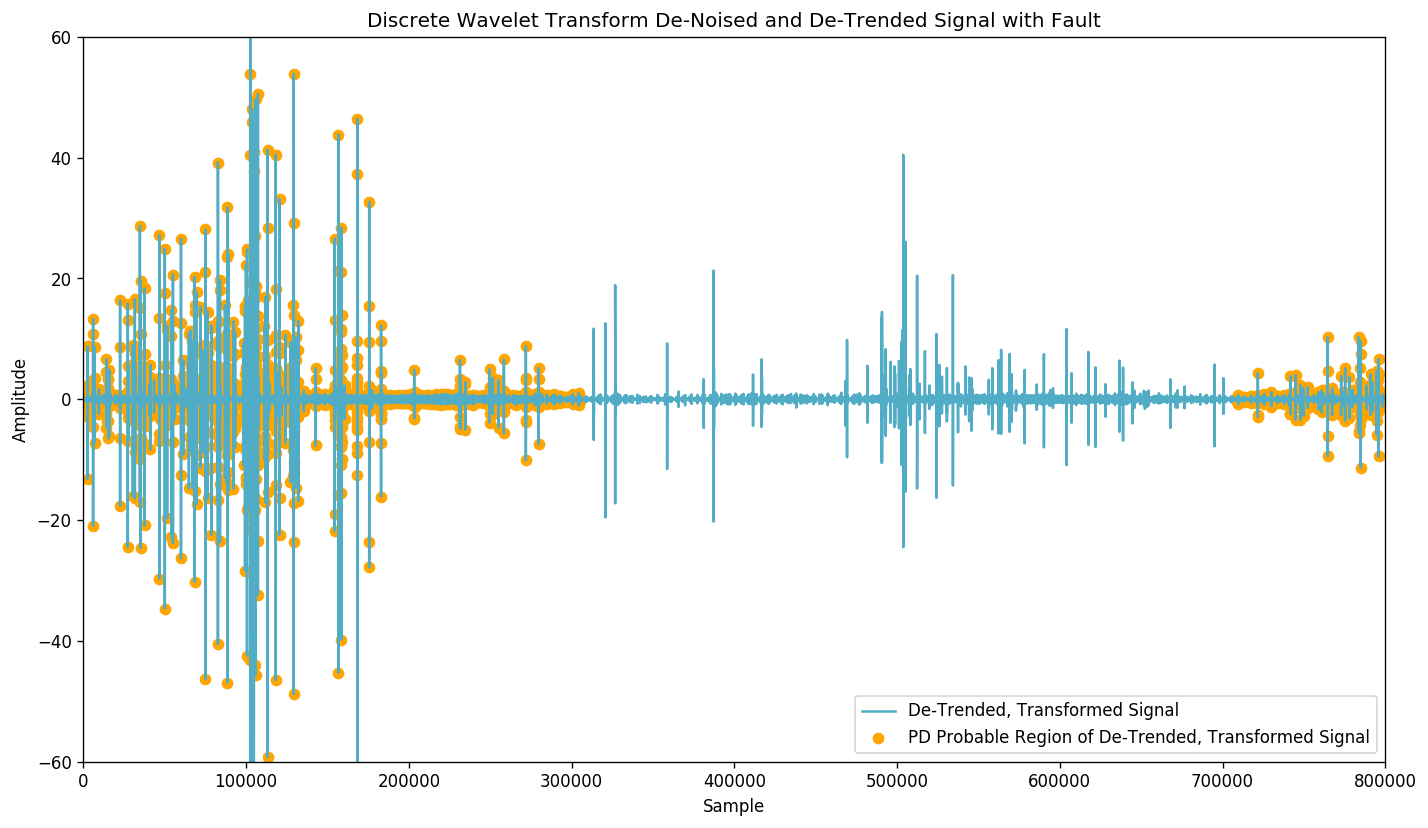

In [8]:
def detrend_signal( signal, high_prob_idx, title=None ):
    
    x = np.diff(signal, n=1)
    if max(high_prob_idx) == len(x):
        high_prob_idx = high_prob_idx[0:-1]
        
    
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color=blues[1], label="De-Trended, Transformed Signal")
    plt.scatter(high_prob_idx, x[high_prob_idx], color="orange", label="PD Probable Region of De-Trended, Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(x)))
    return x[high_prob_idx]


title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0hp =  detrend_signal(signal_0, high_prob_region0, title0)
signal_1hp =  detrend_signal(signal_1, high_prob_region1, title1)

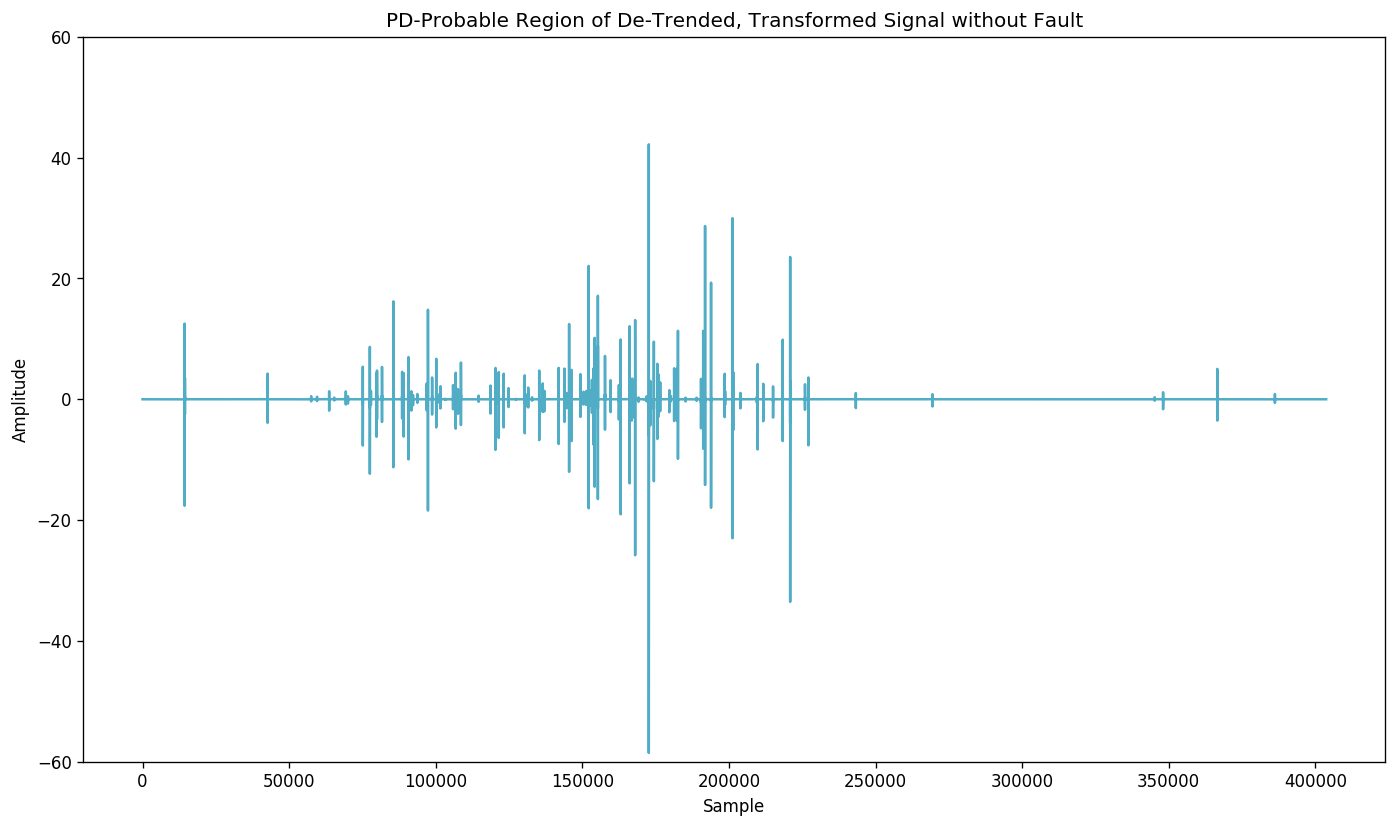

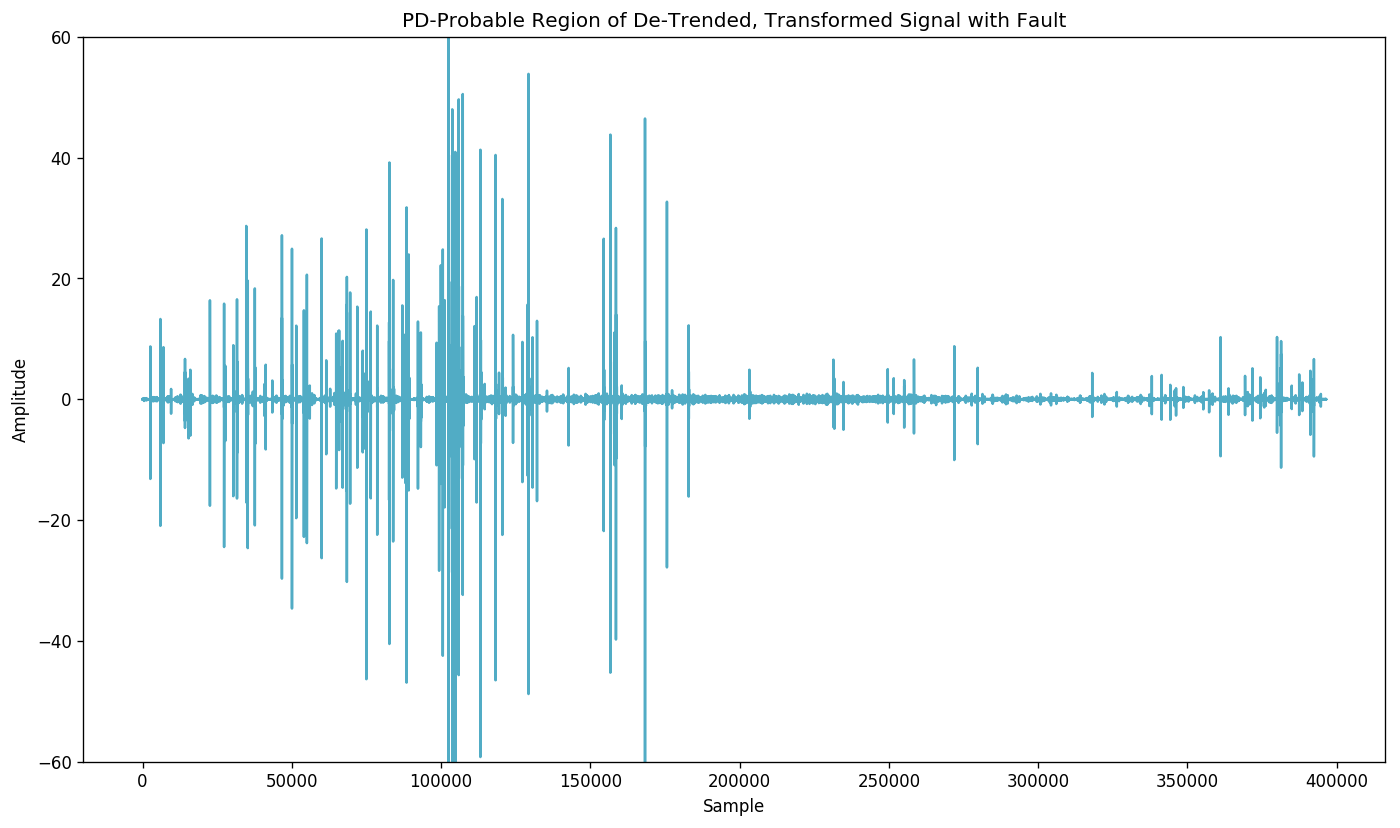

In [9]:
def plot_pd_prob_detrend(signal_hp, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal_hp, color=blues[1])
    plt.ylim((-60, 60))
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(title)
    return

title0 = "PD-Probable Region of De-Trended, Transformed Signal without Fault"
title1 = "PD-Probable Region of De-Trended, Transformed Signal with Fault"
plot_pd_prob_detrend(signal_0hp, title0)
plot_pd_prob_detrend(signal_1hp, title1)

139
478


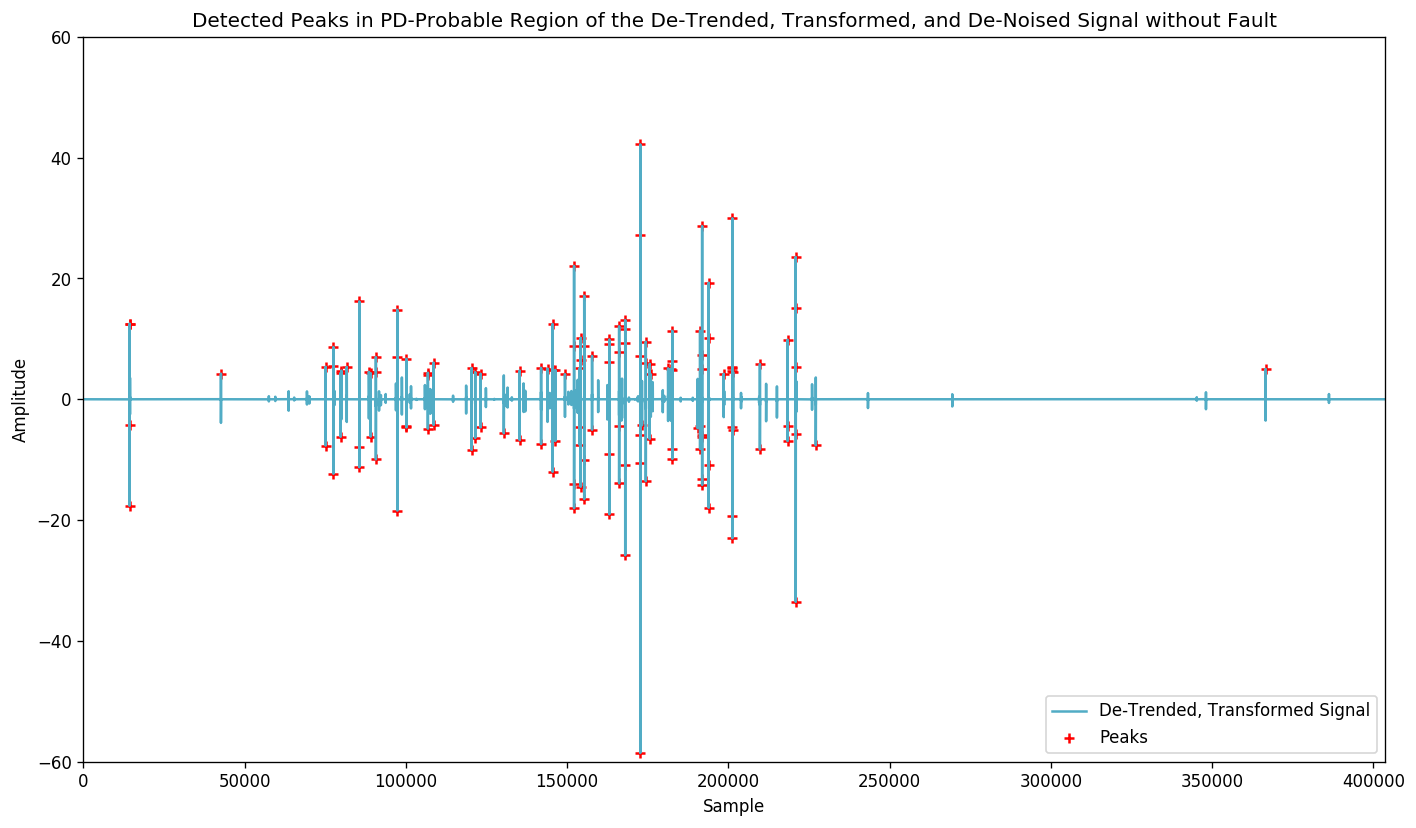

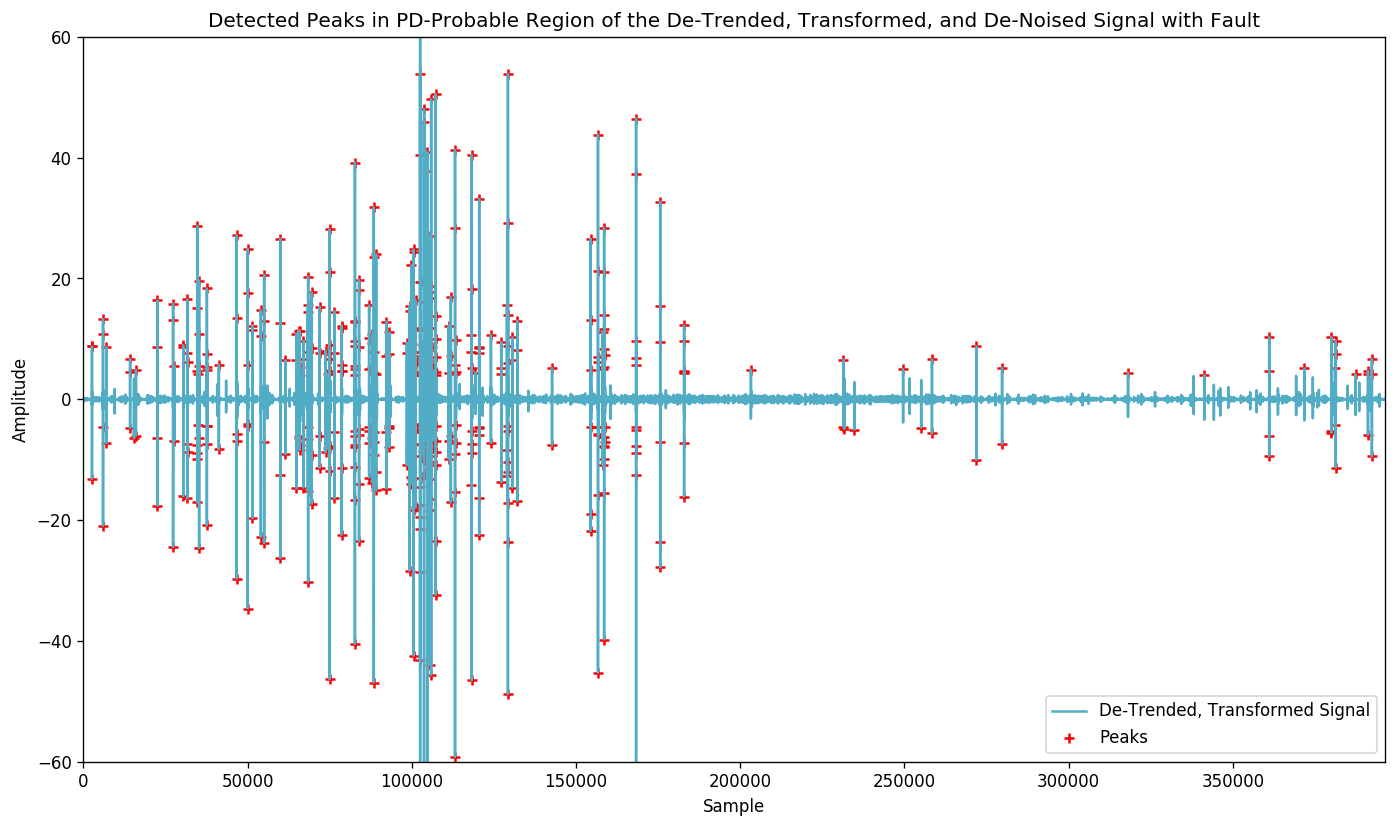

In [10]:
#import peakutils
def find_peaks(signal, title):
    thresh = 0.6  # used for peakutils
    thresh = 4.0  # used for fixed amplitude
    min_d = 0

    #peaks = peakutils.indexes(1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    valleys = np.array(np.argwhere(signal < -thresh))
    pois = np.sort(np.concatenate((peaks, valleys)))
    
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])

    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( signal, color="#51ACC5", label="De-Trended, Transformed Signal" )
    plt.scatter(peak_indexes, signal[peak_indexes], marker="+", color="red", label="Peaks" )
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    print(len(peak_indexes))
    return np.sort(peak_indexes)

title0 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal without Fault'
title1 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal with Fault'
peak_indexes0 = find_peaks(signal_0hp, title=title0 )
peak_indexes1 = find_peaks(signal_1hp, title=title1 )

In [11]:
def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 20  # 
    max_height_ratio = 0.75  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])

            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

false_peak_indexes0 = cancel_false_peaks(signal_0hp, peak_indexes0)
false_peak_indexes1 = cancel_false_peaks(signal_1hp, peak_indexes1)

In [12]:
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    thresh = 30.0
    #peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0) 
    valleys = np.argwhere(signal < -thresh)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return np.sort(false_peak_indexes)

false_peak_indexes0 = cancel_high_amp_peaks(signal_0hp, peak_indexes0, false_peak_indexes0)
false_peak_indexes1 = cancel_high_amp_peaks(signal_1hp, peak_indexes1, false_peak_indexes1)

In [13]:
# Calcel Peaks Flagged as False, Find True Preaks
def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = set(peak_indexes) - set(false_peak_indexes)
    return np.sort(list(true_peak_indexes))

true_peak_indexes0 = cancel_flagged_peaks(peak_indexes0, false_peak_indexes0)
true_peak_indexes1 = cancel_flagged_peaks(peak_indexes1, false_peak_indexes1)

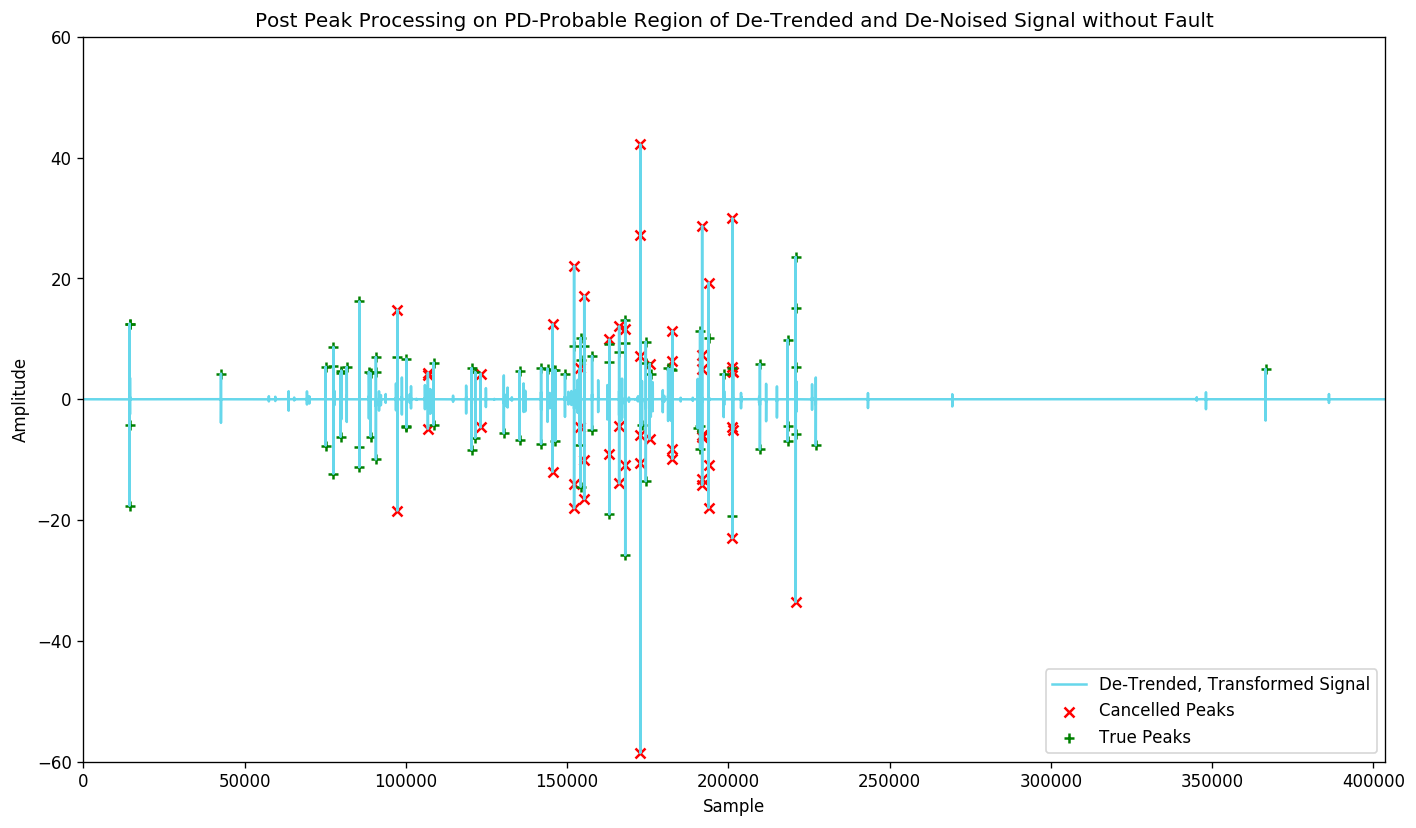

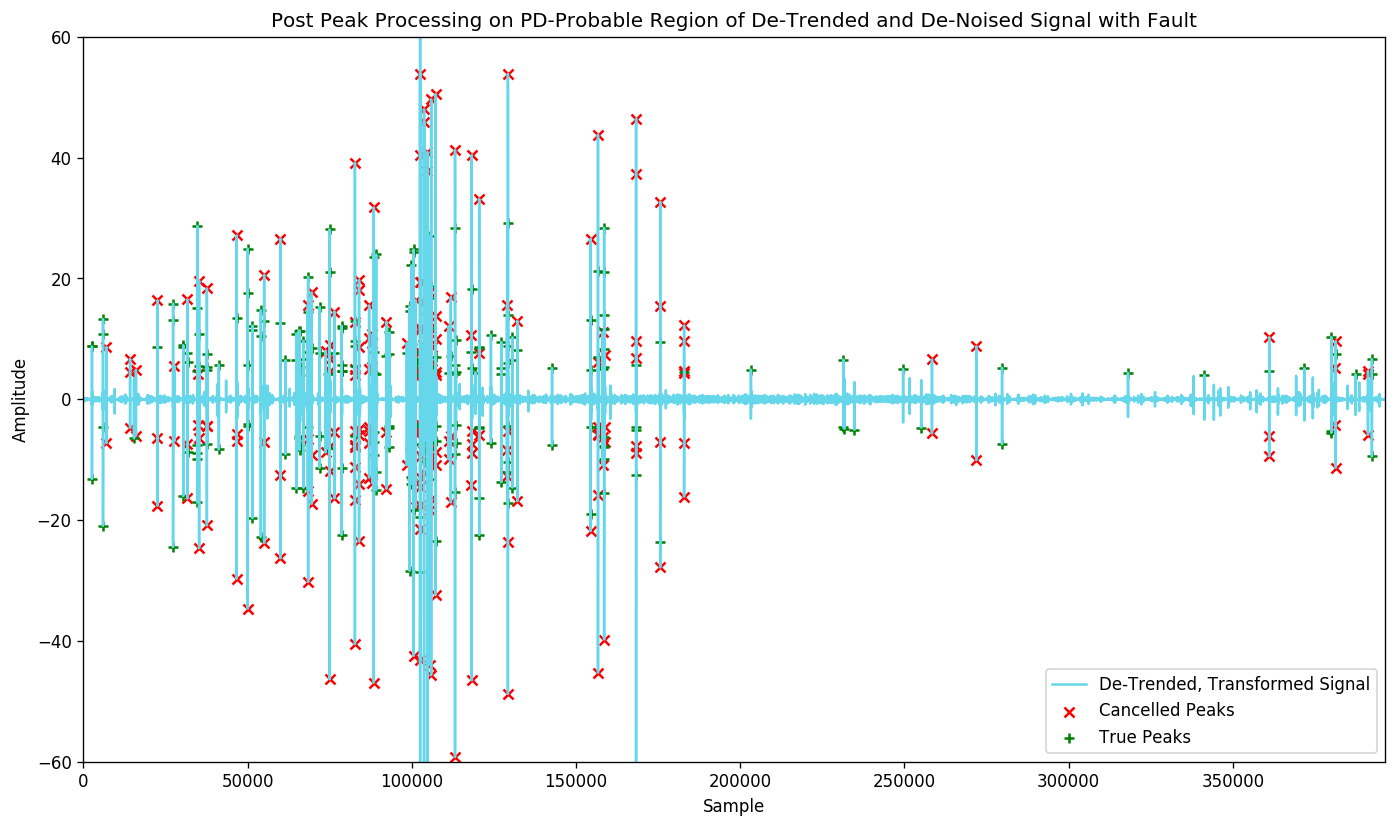

In [14]:
def plot_peaks(signal, true_peak_indexes, false_peak_indexes, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot( signal, color="#66D7EB", label="De-Trended, Transformed Signal" )  #5 alt color 1ACC5
    plt.scatter(false_peak_indexes, signal[false_peak_indexes], marker="x", color="red", label="Cancelled Peaks")
    plt.scatter(true_peak_indexes, signal[true_peak_indexes], marker="+", color="green", label="True Peaks")
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    plt.show()
    return

title0 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal without Fault'
title1 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal with Fault'
plot_peaks(signal_0hp, true_peak_indexes0, false_peak_indexes0, title0)
plot_peaks(signal_1hp, true_peak_indexes1, false_peak_indexes1, title1)

Full feature extraction code (without the per signal looping)

In [15]:
import scipy
from statsmodels.robust import mad
import collections

#  Feature Extraction Functions
def calculate_entropy(signal):
    counter_values = collections.Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def find_all_peaks(signal, threshold=0.7, min_distance=0):
    #peaks = peakutils.indexes(1.0*(signal), thres=threshold, min_dist=min_distance)
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys = peakutils.indexes(-1.0*(signal), thres=threshold, min_dist=min_distance)
    valleys = np.array(np.argwhere(signal < -1.0*threshold))
    pois = np.sort(np.concatenate((peaks, valleys)))
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])
    return np.sort(peak_indexes), peaks, valleys

def calculate_peak_widths(peak_idxs):
    tmp_w = 1
    widths = []
    for idx in range(1,len(peak_idxs)):
        if peak_idxs[idx]-peak_idxs[idx-1] < 3:
            tmp_w +=1
        else:
            widths.append(tmp_w)
            tmp_w = 1
    widths.append(tmp_w)
    min_width = min(np.array(widths))
    max_width = max(np.array(widths))
    mean_width = np.nanmean(np.array(widths))
    num_true_peaks = len(widths)
    return min_width, max_width, mean_width, num_true_peaks

def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 500  # 
    max_height_ratio = 0.25  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:  # opposite polarity and within symmetric check distance
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:  # ratio of opposing polarity check
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)  # build pulse train
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    threshold = 50  # amplitude threshld for determining high amplitude peaks for cancellation
    #peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0)
    valleys = np.argwhere(signal < -1.0*threshold)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx[0] in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return false_peak_indexes

def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    true_peak_indexes.sort()
    return true_peak_indexes

def low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx):
    if np.size(np.array(hi_idx))> 0:
        lhr = 1.0*np.size(np.array(lo_idx))/np.size(np.array(hi_idx))
    else:
        lhr = 0.0
    hi_true = 0
    lo_true = 0
    for x in true_peak_indexes:
        if signal[x] > 0.0:
            hi_true += 1
        else:
            lo_true += 1
    if hi_true > 0:
        lhrt = 1.0*lo_true/hi_true
    else:
        lhrt = 0.0
    return [hi_idx, lo_idx, lhr, hi_true, lo_true, lhrt]

def calculate_peaks(signal, true_peak_indexes):  # Peak Characteristics on True Peaks
    peak_values = signal[true_peak_indexes]
    num_detect_peak = len(true_peak_indexes)
    if num_detect_peak > 0:
        min_height = min(peak_values)
        max_height = max(peak_values)
        mean_height = np.nanmean(peak_values)
        min_width, max_width, mean_width, num_true_peaks = calculate_peak_widths(true_peak_indexes)
        return [min_height, max_height, mean_height, min_width, max_width, mean_width, num_detect_peak, num_true_peaks]
    else:
        return [0, 0, 0, 0, 0, 0, 0, 0]

def get_features(signal, signal_id, threshold, min_distance): # Extract features from the signal and build an array of them
    peak_indexes, hi_idx, lo_idx = find_all_peaks(signal, threshold, min_distance)
    #print("Now processing signal_id: "+str(signal_id)+" with peak detection threshold at "+str(threshold)+" yielding "+str(len(peak_indexes))+" peaks at "+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    false_peak_indexes = cancel_false_peaks(signal, peak_indexes)
    false_peak_indexes = cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes)
    #false_peak_indexes = []  # Don't cancel peaks
    true_peak_indexes = cancel_flagged_peaks(peak_indexes, false_peak_indexes)

    entropy = calculate_entropy(signal)
    statistics = calculate_statistics(signal)
    crossings = calculate_crossings(signal)
    peaks = calculate_peaks(signal, true_peak_indexes)
    low_high_stats = low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx)
    return [entropy] + statistics + crossings + peaks + low_high_stats

threshold = 0.45  # Threshold for db_bit fixed threshold, not peak_detector package
min_distance = 0  # Minimum distance in samples between detected peaks

signal_id = 0  # in this example use signal_id = 0
data_type = "train"  # signal_id 0 belongs to the training set, not the test set in this example
signal_features = get_features(signal_0hp, signal_id, threshold, min_distance)

In [16]:
# Initialize Feature Dataframe
feature_matrix_columns = ["signal_id", "entropy", "n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks", "hi_count", "lo_count", "low_high_ratio", "hi_true", "lo_true", "low_high_ratio_true", "fault"]
feature_matrix = pd.DataFrame([], columns=feature_matrix_columns)

# Store Extracted Features om the Feature MAtrix
#if data_type.lower() == "train":  # Stage Feature Array for Addition to Feature Matrix
#    df_features = pd.DataFrame([[signal_id] + signal_features + [df_meta.target[df_meta.signal_id == signal_id].values[0]]], columns=feature_matrix_columns)
#else:  # for test data
#    df_features = pd.DataFrame([[signal_id] + signal_features + [np.NaN]], columns=feature_matrix_columns)
#feature_matrix = feature_matrix.append(df_features, ignore_index=True)  # Append Feature Matrix Data Frame

# Store feature matrix to CSV (commented out for this notebook, but left in for example.)
#feature_matrix.to_csv("extracted_features/"+data_type+"_features.csv", sep=",")

## Explore Extracted Feature Data
Outside of this notebook, features have been extracted for all signals in the training and test data sets as described above and stored into CSV files. 

This section examines extracted features in the training set, data useful for input into a machine learning model.

In [17]:
import pandas as pd
df_all = pd.read_csv("../input/vsb-features/train_featuresHiLo_thresh_4.5_db4.csv")
features = ["entropy", "n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks", "low_high_ratio", "hi_true", "lo_true", "low_high_ratio_true"]
target = ["fault"]

df = df_all[features+target]
df.describe()

,entropy,n5,n25,n75,n95,median,mean,std,var,rms,no_zero_crossings,no_mean_crossings,min_height,max_height,mean_height,min_width,max_width,mean_width,num_detect_peak,num_true_peaks,low_high_ratio,hi_true,lo_true,low_high_ratio_true,fault
count,8712.000000,8712.000000,8712.000000,8.712000e+03,8.712000e+03,8712.000000,8712.000000,8.712000e+03,8.712000e+03,8.712000e+03,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000,8712.000000
mean,12.900525,-0.096343,-0.015809,1.601850e-02,9.679970e-02,0.000109,0.000101,7.588318e-01,2.445246e+00,7.781633e-02,24683.608815,24751.157943,-5.190373,6.682263,0.265913,0.661731,0.897383,0.700481,8.053375,7.532140,0.745210,4.189279,3.864096,0.635580,0.060262
std,0.025270,0.142419,0.025021,2.506501e-02,1.432543e-01,0.000556,0.000012,1.367346e+00,7.988917e+00,1.365823e-01,18894.731809,18856.957361,8.980170,11.782622,4.182185,0.489837,0.866887,0.529266,18.996759,17.752863,0.503385,10.644660,8.966980,1.249513,0.237985
min,12.855448,-4.547130,-0.266396,6.219655e-08,1.241481e-07,-0.008358,-0.000001,7.265782e-08,5.279159e-15,6.304902e-08,4.000000,20.000000,-49.640912,-21.261297,-28.599492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.895440,-0.153275,-0.020724,3.336753e-04,4.618467e-03,0.000079,0.000093,9.959419e-02,9.919003e-03,7.888530e-03,6012.750000,6171.500000,-6.894233,0.000000,-0.944816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.899390,-0.053116,-0.004395,4.598441e-03,5.379651e-02,0.000096,0.000102,2.435992e-01,5.934056e-02,3.920376e-02,27760.500000,27784.500000,-5.038954,4.999066,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.966475,1.000000,1.000000,0.000000,0.000000
75%,12.903347,-0.004365,-0.000137,2.093086e-02,1.541101e-01,0.000117,0.000109,6.113679e-01,3.737708e-01,8.952858e-02,38667.000000,38702.000000,0.000000,7.291219,1.614124,1.000000,1.000000,1.000000,8.000000,7.000000,1.017050,4.000000,4.000000,1.000000,0.000000
max,13.592366,0.000018,0.000108,2.662385e-01,4.563621e+00,0.008268,0.000284,1.192015e+01,1.420899e+02,2.513143e+00,376314.000000,376312.000000,27.123556,49.965084,34.704982,4.000000,8.000000,4.000000,264.000000,264.000000,7.000000,128.000000,136.000000,30.000000,1.000000


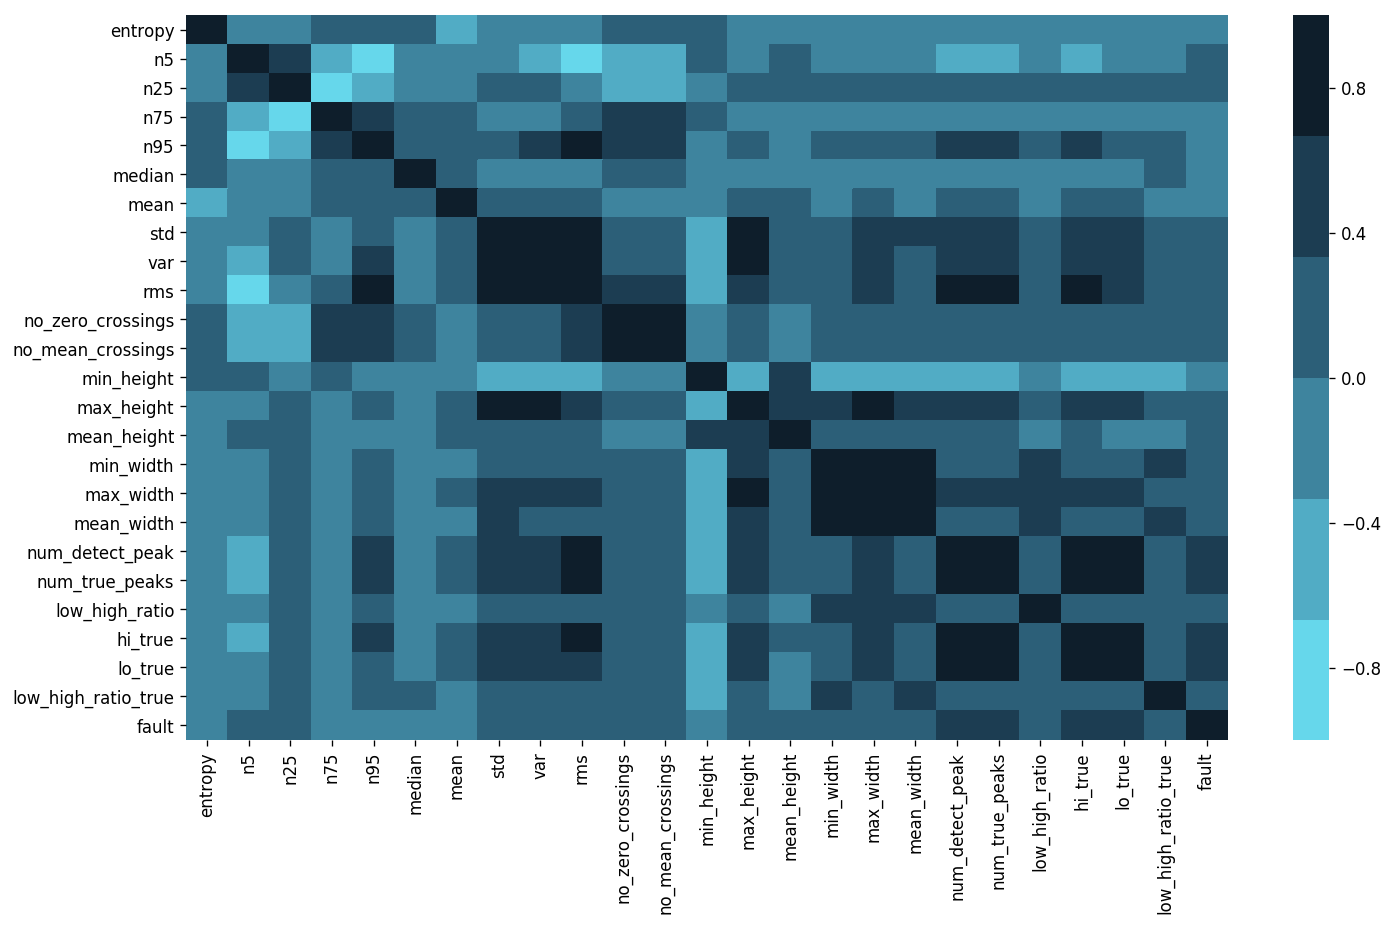

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
cor = df.corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.heatmap(cor, cmap=blues)

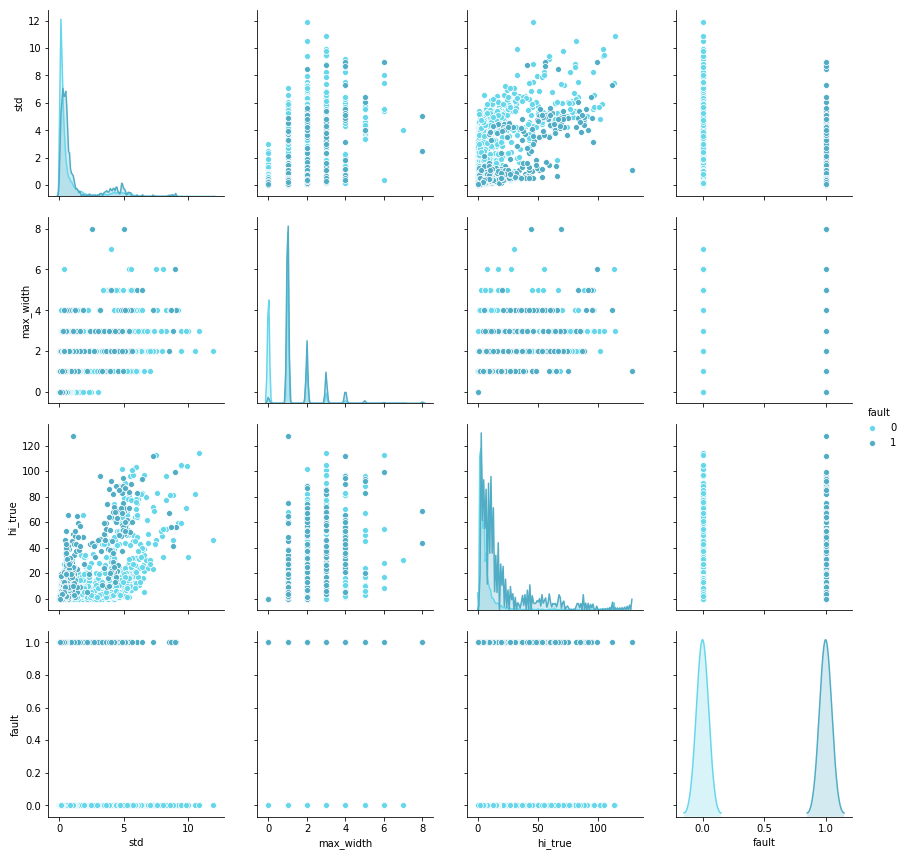

In [19]:
# Detail
sns.pairplot(df[["std", "max_width", "hi_true", "fault"]], hue="fault", palette=blues, height=3, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

# Full (takes a while to execute the full pairplot, uncomment out if you want to dig in)
# sns.pairplot(df, hue="fault", palette=blues, height=3, diag_kind="kde", diag_kws=dict(shade=True, bw=.05, vertical=False) )

In [20]:
#pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(10, 10), diagonal='kde')

## Machine Learning Model
Once all signals havebeen run through signal processing and features extracted and stored in a new CSV file. Load that CSV file into a data frame.

In [21]:
import numpy as np
import pandas as pd
import warnings

## Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_recall_curve


class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                mcc = matthews_corrcoef(Y_valid, valid_pred)
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}, mcc: {}".format(i, j, recall, f1, mcc))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred, clf

def re_predict(data, threshods):
    argmax = np.argmax(data)
    if argmax == 1:
        if data[argmax] >= threshods[argmax] : 
            return 1
        else:
            return 0
    else:  # argmax == 0 
        if data[argmax] >= threshods[argmax] : 
            return 0
        else:
            return 1

In [22]:
# Load Data
features = ["entropy", "n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks", "low_high_ratio", "hi_true", "lo_true", "low_high_ratio_true"]
target = ["fault"]

data_file = "../input/vsb-features/"+"train_featuresHiLo_thresh_4.5_db4.csv"
df_train = pd.read_csv(data_file)
train = df_train[features + target]

data_file = "../input/vsb-features/"+"test_featuresHiLo_thresh_4.5_db4.csv"
df_test = pd.read_csv(data_file)
test = df_test[features]

In [23]:
random_state = 1
class_weight = dict({0:0.5, 1:2.0})

rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
        max_depth=8, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=4, min_samples_split=10,
        min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
        oob_score=False,
        random_state=random_state, verbose=0, warm_start=False)

base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

xtrain = train.drop(['fault'], axis=1)
ytrain = train['fault'].values

train_proba, test_proba, train_pred, test_pred, clf = lgb_stack.predict(xtrain, ytrain, test)

Model- 0 and CV- 0 recall: 0.7681318681318681, f1_score: 0.7729931328439498, mcc: 0.546113314093805
Model- 0 and CV- 1 recall: 0.7707570207570207, f1_score: 0.7660095285972168, mcc: 0.5321352707454371
Model- 0 and CV- 2 recall: 0.7059138377403497, f1_score: 0.7216118823050167, mcc: 0.4451466277454284
Model- 0 and CV- 3 recall: 0.7817988771562382, f1_score: 0.7805483034391684, mcc: 0.5611043826823728
Model- 0 and CV- 4 recall: 0.7469383599499666, f1_score: 0.7480433909200482, mcc: 0.4960939445736931


In [24]:
print('\nPerformance Metrics after Weighted Random Forest Cross Validation')
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, train_pred, average='macro')))
print('3. The Matthews Correlation Coefficient: {}\n'.format(matthews_corrcoef(ytrain, train_pred)))
print('4. Classification report \n {} \n'.format(classification_report(ytrain, train_pred)))
print('5. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, train_pred)))


Performance Metrics after Weighted Random Forest Cross Validation
1. The F-1 score of the model 0.7583892617449665

2. The recall score of the model 0.7547079865291664

3. The Matthews Correlation Coefficient: 0.51685575740977

4. Classification report 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      8187
           1       0.55      0.54      0.55       525

   micro avg       0.95      0.95      0.95      8712
   macro avg       0.76      0.75      0.76      8712
weighted avg       0.95      0.95      0.95      8712
 

5. Confusion matrix 
 [[7960  227]
 [ 243  282]] 



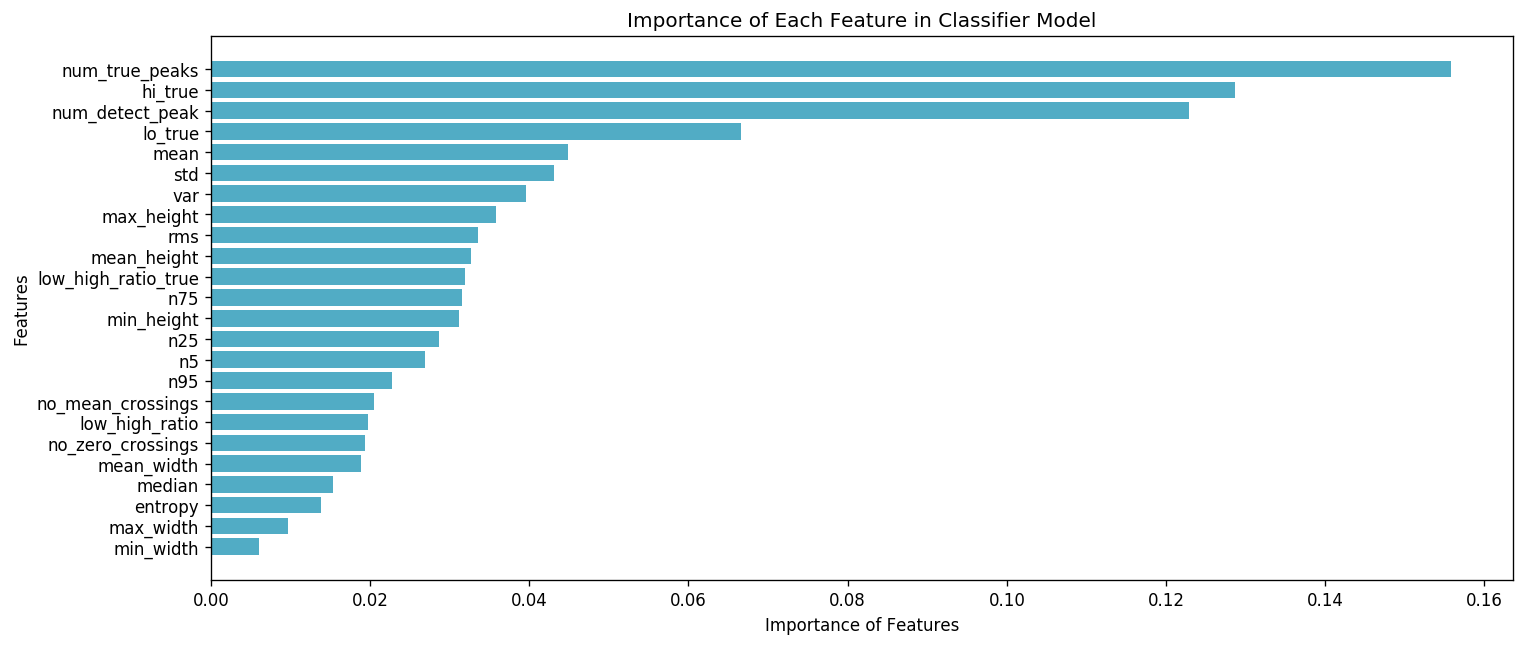

In [25]:
# histogram of important features
imp = clf.feature_importances_
imp, features = zip(*sorted(zip(imp, features)))
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
f, ax = plt.subplots(figsize=(14, 6), dpi= 120, facecolor='w', edgecolor='k')
plt.barh(range(len(features)), imp, color=blues[1], align="center")
plt.yticks(range(len(features)), features)
plt.xlabel("Importance of Features")
plt.ylabel("Features")
plt.title("Importance of Each Feature in Classifier Model")
plt.show()

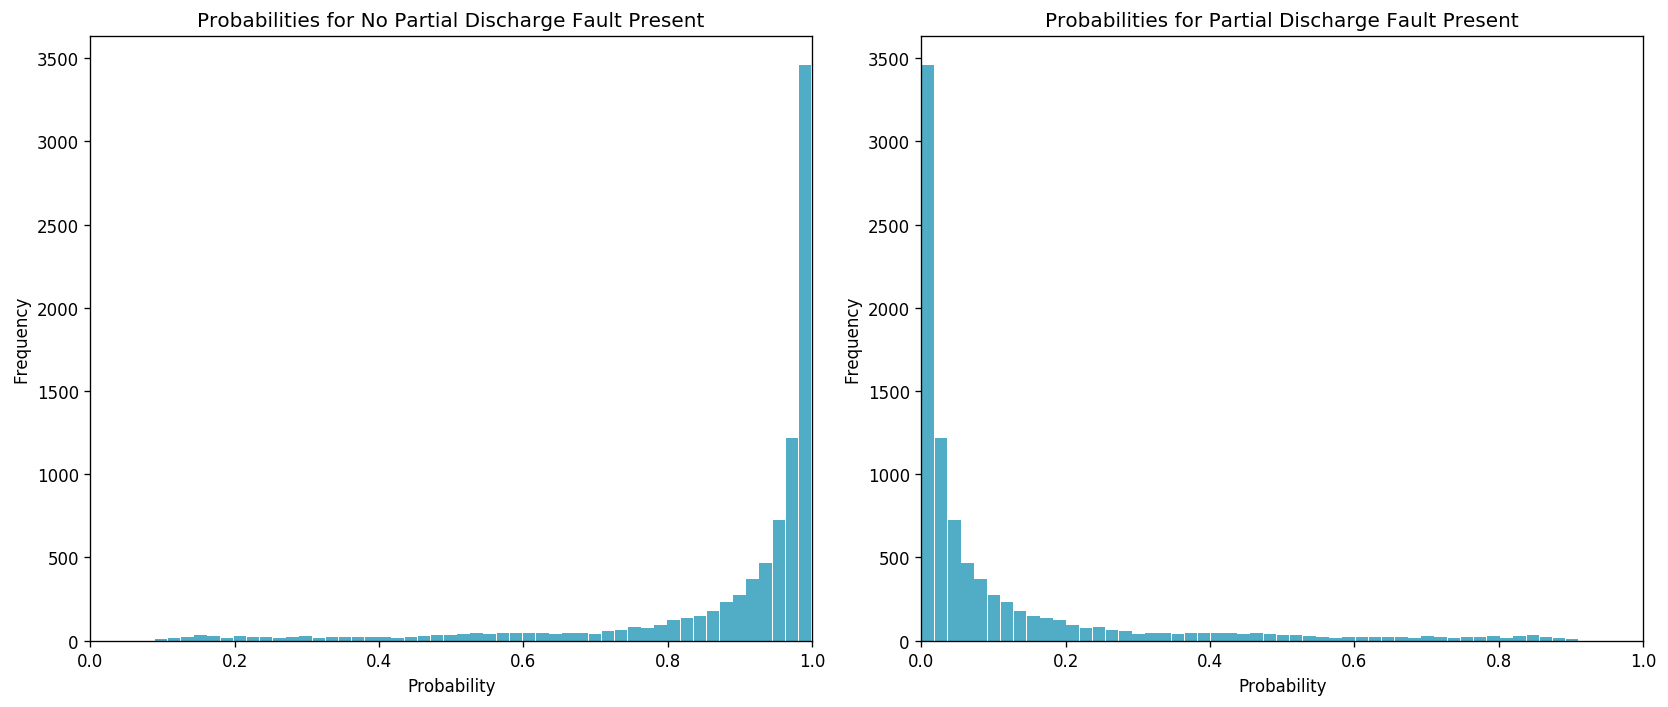

In [26]:
# histogram of predicted probabilities
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
f, ax = plt.subplots(figsize=(14, 6), dpi= 120, facecolor='w', edgecolor='k')
nclasses = 2
titles = ["Probabilities for No Partial Discharge Fault Present", "Probabilities for Partial Discharge Fault Present"]
for i in range(nclasses):
    plt.subplot(1, nclasses, i+1)
    plt.hist(train_proba[:, i], bins=50, histtype='bar', rwidth=0.95, color=blues[1])
    plt.xlim(0,1)
    plt.title(titles[i])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [27]:
y = label_binarize(ytrain, classes=[0, 1])
_, _, th1 = roc_curve(y[:, 0], train_proba[:, 0])
_, _, th2 = roc_curve(y[:, 0], train_proba[:, 1])
print('\nMedian Detection Thresholds for Fault Detection')  # use for setting reprediction thresholds
print(np.median(th1))
print(np.median(th2))


Median Detection Thresholds for Fault Detection
0.8151273183119299
0.18503062550668267


Repredict with new thresholds

In [28]:
threshold = [0.5, 0.1]
new_pred = []
for i in range(train_pred.shape[0]):
    new_pred.append(re_predict(train_proba[i, :], threshold))
print('\nPerformance Metrics after Over Prediction')
print('1. The F-1 score of the model {}\n'.format(f1_score(ytrain, new_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytrain, new_pred, average='macro')))
print('3. The Matthews Correlation Coefficient: {}\n'.format(matthews_corrcoef(ytrain, new_pred)))
print('4. Classification report \n {} \n'.format(classification_report(ytrain, new_pred)))
print('5. Confusion matrix \n {} \n'.format(confusion_matrix(ytrain, new_pred)))


Performance Metrics after Over Prediction
1. The F-1 score of the model 0.7583892617449665

2. The recall score of the model 0.7547079865291664

3. The Matthews Correlation Coefficient: 0.51685575740977

4. Classification report 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      8187
           1       0.55      0.54      0.55       525

   micro avg       0.95      0.95      0.95      8712
   macro avg       0.76      0.75      0.76      8712
weighted avg       0.95      0.95      0.95      8712
 

5. Confusion matrix 
 [[7960  227]
 [ 243  282]] 



Create submission file

In [29]:
test_pred = np.median(test_pred, axis=1).astype(int)
df_test["fault"] = test_pred

# Make Submission File
submission_filename = "submissions/prediction_submission_cv.csv"

# Commented out in this notebook but left in as an example to create a submission file
#f_o = open(submission_filename, "w+")
#f_o.write("signal_id,target\n")
#for idx in range(len(df_test)):
#    signal_id = df_test["signal_id"][idx]
#    fault = df_test["fault"][idx]
#    f_o.write(str(signal_id)+","+str(fault)+"\n")
#f_o.close()

## Final Leaderboard
Kaggle enables the export of a CSV of public leaderboard data. The following code explored my team's score progession as well as plotting where our best score ended up in the (nearly) final results.

In [30]:
import pandas as pd
# Load The Public Leaderboard Score Data - Last Updated on 27 February 2019
lb = pd.read_csv("../input/vsb-lb/vsb-power-line-fault-detection-publicleaderboard.csv")

In [31]:
mine = lb[lb.TeamName == "dragonaur.io"]
mine  # Review my scores progression

,TeamId,TeamName,SubmissionDate,Score
1552,2639077,dragonaur.io,2019-01-21 03:35:17,0.340
2484,2639077,dragonaur.io,2019-02-02 17:47:25,0.428
2874,2639077,dragonaur.io,2019-02-10 13:57:51,0.434
3727,2639077,dragonaur.io,2019-02-28 02:19:12,0.453


In [32]:
teams = lb.TeamId.unique()  # Array of TeamIds (prune duplicates from people progressing)
scores = []
for team in teams:  # Build Array of Each Team's Best (e.g. Latest Leaderboard Score)
    scores.append(lb.Score[lb.TeamId == team].max())

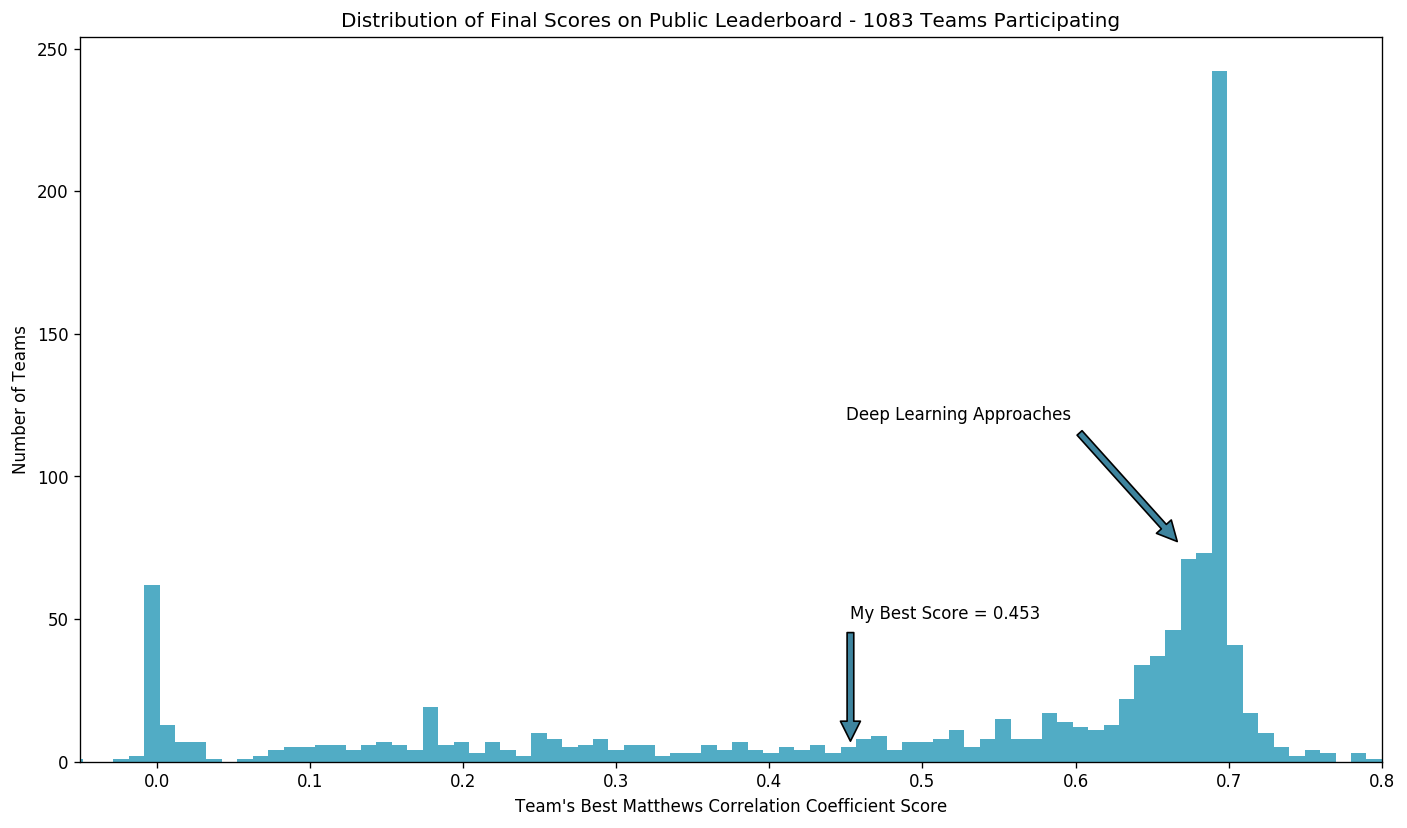

In [33]:
from matplotlib import pyplot as plt
my_best_score = lb.Score[lb.TeamName == "dragonaur.io"].max()  # May need to adjust height of annotations as scores change
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.hist(scores, bins=101, color=blues[1])
plt.xlim((-0.05, 0.8))
ax.annotate('My Best Score = '+str(round(my_best_score,4)), xy=(my_best_score, 5), xytext=(my_best_score,50), arrowprops=dict(facecolor=blues[2], shrink=0.05))
ax.annotate("Deep Learning Approaches", xy=(0.67, 75), xytext=(0.45,120), arrowprops=dict(facecolor=blues[2], shrink=0.05))
plt.title('Distribution of Final Scores on Public Leaderboard - '+str(len(scores))+' Teams Participating')
plt.ylabel('Number of Teams')
plt.xlabel("Team's Best Matthews Correlation Coefficient Score")
plt.show()

From, the forums it appears that most people with models scoring greater than 0.6 are using deep learning methods and neural networks instead of relying on feature-based approaches that require signal processing.

## Improvements
There are notably at least two promising paths to improve performance of partial discharge fault detection models, this model included.

### Transition Data Collection and Processing from Single Cycle to a N Cycle Accumulator
Moving from collecting and processing one 50Hz grid cycle to sampling N consecutive samples would benefit partial discharge faults in a number of ways. First and foremost, the sample size is larger. But more importantly it offers the opportunity to improve detection of persistent partial discharge patterns while mitigating sporadic effects like corona discharge. At a minimum, measurement data should be tagged with a collector ID so that the same length of covered conductor can be assessed over time. This data should come for free since presumably, if a fault is detected, the power company is going to want to know where to dispatch repair crews.

### Leverage Grouped Faults in the Prediction Model
While not universally true, when a measurement contains a fault in one of the signal phases, a fault is present on at least one of the other phases as well. In the provided, labeled training data 90.1% of the time, this observation holds true. It may be possible to implement a M of N voting system for better fault detection but care must be taken to not introduce additional error and bias.  
